# Analisis generarl de la serie de tiempo
Se crea una rutina de reportes para poder visualizar el estado de la serie temporal, la idea es comenzar desde el analisis general de la serie hasta el analisis especifico como analisis mensual y diario.
Con esto se pretende generar una serie de metricas para determinar que metodos de intermpolacion podemos utilizar para la imputacion de datos ausentes.

In [1]:
import kaleido
import ephem
import numpy as np
import pandas as pd
from utils.utils import reshample_time_serie, categorize_precipitation
from statistics_utils.eda.timeseries import decompose_time_series
#from graphics_utils.go import arrange_figures_in_subplots


In [2]:
from api_somo import DataFetcher, fetch_qf 
import logging

# Setting up logging for the main script
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

api_url = "http://127.0.0.1:8000/database/filter-serie/"
params = {
    "station_name": "tumaco",
    "variable_name": "Precipitación acumulada",
    "processing_level_name": "Control de calidad",
    "start_date":"2011-01-01",
    "end_date":"2011-12-31"
    }

try:
    # 1. Fetch and process the data
    historical_series = DataFetcher.fetch_and_process_data(api_url, params)

    if historical_series.empty:
        raise ValueError("The historical series is empty.")

    # Additional processing with the historical series
    logger.info(f"Fetched historical series: {historical_series.head(0)}")

except Exception as e:
    logger.error(f"Error fetching historical series: {e}")


# Resample de la serie de tiempo y rellenar valores faltantes iniciales con interpolación básica

historical_series = reshample_time_serie(historical_series, 'D', 'sum')
historical_series = categorize_precipitation(historical_series, params)
serie_reporte=historical_series.copy()
serie_reporte.loc[serie_reporte['qf'] == 9, 'value'] = np.nan
print(serie_reporte.describe())


INFO:api_somo:Sending request to http://127.0.0.1:8000/database/filter-serie/ with parameters: {'station_name': 'tumaco', 'variable_name': 'Precipitación acumulada', 'processing_level_name': 'Control de calidad', 'start_date': '2011-01-01', 'end_date': '2011-12-31'}
INFO:api_somo:Original columns: ['date_time', 'sensor_data', 'quality_flag']
INFO:api_somo:Columns after renaming: ['timestamp', 'value', 'qf']
INFO:api_somo:Timestamp conversion and indexing complete.
INFO:__main__:Fetched historical series: Empty DataFrame
Columns: [value, qf]
Index: []


            value          qf
count  346.000000  365.000000
mean     5.326301    1.416438
std     11.944744    1.779540
min      0.000000    1.000000
25%      0.000000    1.000000
50%      0.500000    1.000000
75%      5.225000    1.000000
max    115.200000    9.000000


---
# Analisis de la calidad de la serie Historica
En este grafico podemos ver el total de datos agrupados por calidad en cada mes, es decir si una serie tiene 15 años tiene 15 eneros, 15 noviembres etc, con esta grafica podemos ver a modo general con cuantos datos del total contamos para la recuperacion de la serie y los datos faltantes, esta grafica es muy importante porque nos da  un marcador de calidad historico por meses, incluso aqui se puede analizar si la perdida de datos es sistematica o si tiene algun comportamiento con correlacion temporal.

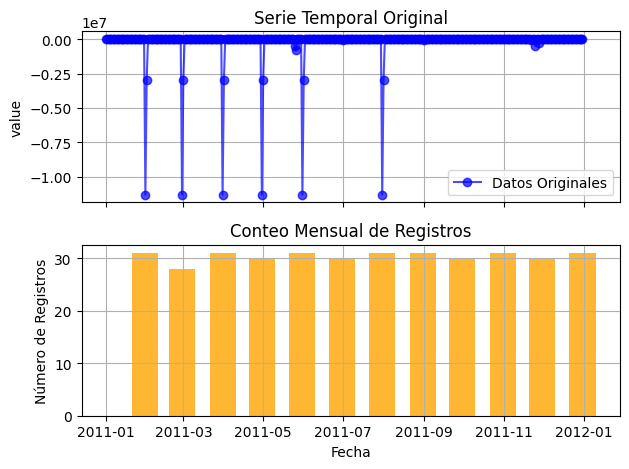

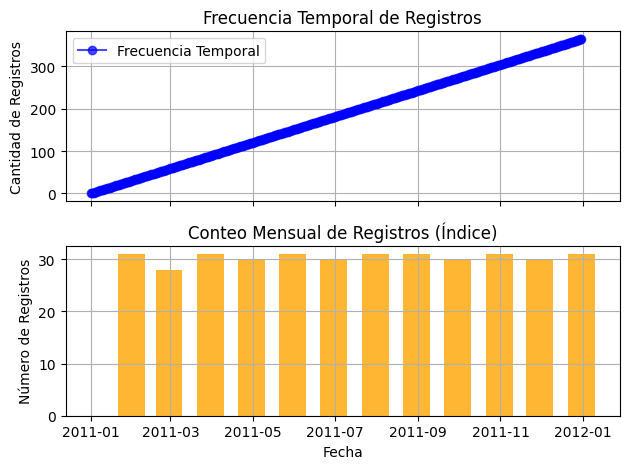

timestamp
2011-01-31 00:00:00+00:00    31
2011-02-28 00:00:00+00:00    28
2011-03-31 00:00:00+00:00    31
2011-04-30 00:00:00+00:00    30
2011-05-31 00:00:00+00:00    31
2011-06-30 00:00:00+00:00    30
2011-07-31 00:00:00+00:00    31
2011-08-31 00:00:00+00:00    31
2011-09-30 00:00:00+00:00    30
2011-10-31 00:00:00+00:00    31
2011-11-30 00:00:00+00:00    30
2011-12-31 00:00:00+00:00    31
Freq: ME, Name: timestamp, dtype: int64


In [3]:
from utils.utils import _count, analyze_time_series, analyze_time_series_index
analyze = analyze_time_series(historical_series)
report_index = analyze_time_series_index(historical_series)
print(report_index)

In [4]:
from graphics_utils.express import fig_pie_month, fig_boxplot, fig_lineplot

print(historical_series[historical_series['qf'] == 9])


line_fig = fig_lineplot(historical_series, params, color=None)
line_fig.show()
"""pie_fig = fig_pie_month(serie_historica, params)
pie_fig.show()
boxplot_fig = fig_boxplot(serie_historica, params, color='month')
boxplot_fig.show()"""

                                value  qf        category
timestamp                                                
2011-01-31 00:00:00+00:00 -11299887.0   9  Lluvia extrema
2011-02-01 00:00:00+00:00  -2999961.7   9  Lluvia extrema
2011-02-28 00:00:00+00:00 -11299887.0   9  Lluvia extrema
2011-03-01 00:00:00+00:00  -2999970.0   9  Lluvia extrema
2011-03-31 00:00:00+00:00 -11299887.0   9  Lluvia extrema
2011-04-01 00:00:00+00:00  -2999969.6   9  Lluvia extrema
2011-04-30 00:00:00+00:00 -11299887.0   9  Lluvia extrema
2011-05-01 00:00:00+00:00  -2999970.0   9  Lluvia extrema
2011-05-25 00:00:00+00:00   -499988.4   9  Lluvia extrema
2011-05-26 00:00:00+00:00   -799967.8   9  Lluvia extrema
2011-05-31 00:00:00+00:00 -11299877.9   9  Lluvia extrema
2011-06-01 00:00:00+00:00  -2999970.0   9  Lluvia extrema
2011-07-01 00:00:00+00:00    -99999.0   9  Lluvia extrema
2011-07-31 00:00:00+00:00 -11299887.0   9  Lluvia extrema
2011-08-01 00:00:00+00:00  -2999968.3   9  Lluvia extrema
2011-09-01 00:

"pie_fig = fig_pie_month(serie_historica, params)\npie_fig.show()\nboxplot_fig = fig_boxplot(serie_historica, params, color='month')\nboxplot_fig.show()"

In [5]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Filtrar solo valores válidos (descartar NaN y valores de calidad errónea)
serie_valida = historical_series.loc[historical_series['value'] != -99987.6, 'value']

# Correlación Total (ACF)
plt.figure(figsize=(10, 6))
plot_acf(serie_valida, lags=100, title="Autocorrelación (ACF)")
plt.show()

# Correlación Parcial (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(serie_valida, lags=100, title="Autocorrelación Parcial (PACF)")
plt.show()


import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
import plotly.graph_objects as go

# Filtrar solo valores válidos (descartar NaN y valores de calidad errónea)
serie_valida = historical_series.loc[historical_series['value'] != -99999, 'value']

# Calcular valores de ACF y PACF con intervalos de confianza
max_lags = len(serie_valida) // 2

lags = 260  # Número de retardos
acf_values, confint_acf = acf(serie_valida, nlags=max_lags, alpha=0.05, fft=True)
pacf_values, confint_pacf = pacf(serie_valida, nlags=max_lags, alpha=0.05, method='ywmle')

# Crear gráfico para ACF con intervalos de confianza
fig_acf = go.Figure()

# Añadir las barras de ACF
fig_acf.add_trace(go.Bar(x=np.arange(len(acf_values)), y=acf_values, name="ACF"))

# Añadir los intervalos de confianza
fig_acf.add_trace(
    go.Scatter(
        x=np.arange(len(acf_values)),
        y=confint_acf[:, 0] - acf_values,
        mode='lines',
        line=dict(color="rgba(0,0,0,0.2)"),
        name="Límite Inferior",
        showlegend=False
    )
)
fig_acf.add_trace(
    go.Scatter(
        x=np.arange(len(acf_values)),
        y=confint_acf[:, 1] - acf_values,
        mode='lines',
        fill='tonexty',
        line=dict(color="rgba(0,0,0,0.2)"),
        name="Límite Superior",
        showlegend=False
    )
)

fig_acf.update_layout(
    title="Autocorrelación (ACF) con Intervalos de Confianza",
    xaxis_title="Lag",
    yaxis_title="Autocorrelación",
    template="plotly_white"
)
fig_acf.show()

# Crear gráfico para PACF con intervalos de confianza
fig_pacf = go.Figure()

# Añadir las barras de PACF
fig_pacf.add_trace(go.Bar(x=np.arange(len(pacf_values)), y=pacf_values, name="PACF"))

# Añadir los intervalos de confianza
fig_pacf.add_trace(
    go.Scatter(
        x=np.arange(len(pacf_values)),
        y=confint_pacf[:, 0] - pacf_values,
        mode='lines',
        line=dict(color="rgba(0,0,0,0.2)"),
        name="Límite Inferior",
        showlegend=False
    )
)
fig_pacf.add_trace(
    go.Scatter(
        x=np.arange(len(pacf_values)),
        y=confint_pacf[:, 1] - pacf_values,
        mode='lines',
        fill='tonexty',
        line=dict(color="rgba(0,0,0,0.2)"),
        name="Límite Superior",
        showlegend=False
    )
)

fig_pacf.update_layout(
    title="Autocorrelación Parcial (PACF) con Intervalos de Confianza",
    xaxis_title="Lag",
    yaxis_title="Autocorrelación Parcial",
    template="plotly_white"
)
fig_pacf.show()


# Redes neuronales recurentes

1. Preparar los datos
- Asegúrate de que los datos estén normalizados o estandarizados si las variables tienen diferentes escalas.

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from graphics_utils.go import multi_line  # Asegúrate de que `graphics_utils.go` esté correctamente importado

# Reemplazar valores de calidad (qf == 9) con NaN
historical_series.loc[historical_series['qf'] == 9, 'value'] = np.nan
datos = historical_series[['value']].copy()

# Crear una columna con el valor retrasado (lag)
datos['value_lag'] = datos['value'].shift(20)

# Eliminar filas con NaN en 'value' o 'value_lag' para entrenar el modelo
datos_entrenamiento = datos.dropna()

# Preprocesar los datos para la red neuronal
# Definir las variables X e Y
X = datos_entrenamiento[['value_lag']].values
y = datos_entrenamiento['value'].values

# Reshape de X para que sea compatible con el LSTM (n_samples, n_timesteps, n_features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Dividir los datos en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo LSTM
modelo = Sequential()
modelo.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
modelo.add(Dense(1))  # Una salida (valor imputado)
modelo.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
modelo.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Realizar predicciones sobre el conjunto de validación
y_pred = modelo.predict(X_val)

# Coeficiente de determinación (R²)
r2 = r2_score(y_val, y_pred)
print('Coeficiente de determinación (R²): ', round(r2, 2))

# Filtrar las filas donde 'value' es NaN y 'value_lag' no es NaN para imputar valores
datos_faltantes = datos.loc[datos['value'].isna() & datos['value_lag'].notna(), 'value_lag']

# Predecir los valores faltantes usando el modelo
X_faltantes = datos_faltantes.values.reshape((-1, 1, 1))  # Asegurarse de que tiene la forma correcta
datos.loc[datos_faltantes.index, 'value_imputed'] = modelo.predict(X_faltantes)

# Asegurar que 'value_imputed' esté completa (sin NaN)
datos['value_imputed'].fillna(datos['value'], inplace=True)

# Imprimir el DataFrame para ver resultados
print(datos)

# Visualizar los resultados con multi_line
fig = multi_line(CCCP=datos['value'], Imputadas=datos['value_imputed'])
fig.show()


"import numpy as np\nimport pandas as pd\nfrom sklearn.metrics import r2_score\nimport matplotlib.pyplot as plt\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Dense\nfrom sklearn.model_selection import train_test_split\nfrom graphics_utils.go import multi_line  # Asegúrate de que `graphics_utils.go` esté correctamente importado\n\n# Reemplazar valores de calidad (qf == 9) con NaN\nserie_historica.loc[serie_historica['qf'] == 9, 'value'] = np.nan\ndatos = serie_historica[['value']].copy()\n\n# Crear una columna con el valor retrasado (lag)\ndatos['value_lag'] = datos['value'].shift(20)\n\n# Eliminar filas con NaN en 'value' o 'value_lag' para entrenar el modelo\ndatos_entrenamiento = datos.dropna()\n\n# Preprocesar los datos para la red neuronal\n# Definir las variables X e Y\nX = datos_entrenamiento[['value_lag']].values\ny = datos_entrenamiento['value'].values\n\n# Reshape de X para que sea compatible con el LSTM (n_samples, n_timesteps, n_f

---
## Imputación con KNN
Imputar datos faltantes utilizando los k vecinos más cercanos (k-nearest neighbors, KNN) es una técnica común y efectiva, especialmente para conjuntos de datos en los que los valores tienen una correlación espacial, temporal o de características entre ellos.

In [7]:
'''historical_series.loc[historical_series['qf'] != 1, 'value'] = np.nan

from sklearn.impute import KNNImputer

# Configurar el imputador con KNN
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# Realizar la imputación solo en la columna 'values' y mantener el índice 'timestamp'
serie_historica_impitada=historical_series.copy()
serie_historica_impitada['value'] = imputer.fit_transform(serie_historica_impitada[['value']])


from graphics_utils.go import multi_line
fig = multi_line(CCCP=historical_series['value'], Imputadas=serie_historica_impitada['value'])
fig.show()
'''

"serie_historica.loc[serie_historica['qf'] != 1, 'value'] = np.nan\n\nfrom sklearn.impute import KNNImputer\n\n# Configurar el imputador con KNN\nimputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')\n\n# Realizar la imputación solo en la columna 'values' y mantener el índice 'timestamp'\nserie_historica_impitada=serie_historica.copy()\nserie_historica_impitada['value'] = imputer.fit_transform(serie_historica_impitada[['value']])\n\n\nfrom graphics_utils.go import multi_line\nfig = multi_line(CCCP=serie_historica['value'], Imputadas=serie_historica_impitada['value'])\nfig.show()\n"

# Descomponer la serie temporal
Esta seccion se crea para hacer el procesamiento de descomposicion

In [8]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from graphics_utils.go import multi_line  # Asegúrate de importar correctamente tu función

# Reemplazar valores de calidad (qf == 9) con NaN
historical_series.loc[historical_series['qf'] == 9, 'value'] = np.nan
datos = historical_series[['value']]
datos['value'] = datos['value'].interpolate(method='time')

# Parámetros SARIMA
p, d, q = 1, 0, 2
P, D, Q, S = 2, 1, 1, 30

# Ajustar el modelo SARIMA
modelo_sarima = SARIMAX(datos['value'], order=(p, d, q), seasonal_order=(P, D, Q, S),n_jobs=-1)
modelo_ajustado = modelo_sarima.fit(disp=False)


C:\Users\dreng\AppData\Local\Temp\ipykernel_23676\90979703.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['n_jobs']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [9]:
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from graphics_utils.go import multi_line  # Asegúrate de importar correctamente tu función

# Reemplazar valores de calidad (qf == 9) con NaN
historical_series.loc[historical_series['qf'] == 9, 'value'] = np.nan
datos = historical_series[['value']]
datos['value'] = datos['value'].interpolate(method='time')

# Aplicar Auto-ARIMA para encontrar los mejores parámetros
modelo_autoarima = auto_arima(
    datos['value'],
    start_p=0, max_p=3,            # Rango para p (Autorregresivo)
    start_q=0, max_q=3,            # Rango para q (Media Móvil)
    start_P=0, max_P=2,            # Rango para P (Estacional)
    start_Q=0, max_Q=2,            # Rango para Q (Estacional)
    d=None,                        # Determina automáticamente el grado de diferenciación
    seasonal=True,                 # Habilitar componentes estacionales
    m=30,                          # Periodo estacional (30 días en este caso)
    trace=True,                    # Mostrar progreso del modelo
    n_jobs=-1,
    error_action='ignore',         # Ignorar errores y continuar
    suppress_warnings=True,        # Suprimir advertencias
    stepwise=True                  # Usar búsqueda escalonada para mayor velocidad
)

# Resultados del modelo seleccionado
print(f"Mejores parámetros encontrados por Auto-ARIMA: {modelo_autoarima.order} (SARIMA)")
print(f"Parámetros estacionales: {modelo_autoarima.seasonal_order}")

# Ajustar el modelo SARIMA con los parámetros obtenidos por Auto-ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

mejores_parametros = modelo_autoarima.order
mejores_parametros_estacionales = modelo_autoarima.seasonal_order

modelo_sarima_final = SARIMAX(
    datos['value'],
    order=mejores_parametros,
    seasonal_order=mejores_parametros_estacionales
)
modelo_ajustado_final = modelo_sarima_final.fit(disp=False)

# Resumen del modelo
print(modelo_ajustado_final.summary())


C:\Users\dreng\AppData\Local\Temp\ipykernel_23676\1471531194.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=3013.888, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=2943.202, Time=0.45 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=3011.888, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=2941.263, Time=0.04 sec
 ARIMA(1,1,0)(0,0,1)[30] intercept   : AIC=2943.192, Time=0.43 sec
 ARIMA(1,1,0)(1,0,1)[30] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(2,1,0)(0,0,0)[30] intercept   : AIC=2906.806, Time=0.07 sec
 ARIMA(2,1,0)(1,0,0)[30] intercept   : AIC=2908.806, Time=0.69 sec
 ARIMA(2,1,0)(0,0,1)[30] intercept   : AIC=2908.806, Time=0.82 sec
 ARIMA(2,1,0)(1,0,1)[30] intercept   : AIC=2910.758, Time=1.99 sec
 ARIMA(3,1,0)(0,0,0)[30] intercept   : AIC=2880.563, Time=0.31 sec
 ARIMA(3,1,0)(1,0,0)[30] intercept   : AIC=2882.474, Time=0.72 sec
 ARIMA(3,1,0)(0,0,1)[30] intercept   : AIC=2882.468, Time=0.72 sec
 ARIMA(3,1,0)(1,0,1)[30] inte

In [10]:

# Predicciones
predicciones = modelo_ajustado_final.predict(start=0, end=len(datos)-1)

# Métrica de error (opcional)
rmse = np.sqrt(mean_squared_error(datos['value'], predicciones))
print(f"RMSE del modelo final: {rmse}")

# Visualización de la serie original y las predicciones
multi_line(Datos_Originales= datos['value'],Predicciones= predicciones)


RMSE del modelo final: 11.48785576275951


In [11]:

# Predecir valores (incluyendo los NaN)
# Asegurar que las predicciones no sean negativas
predicciones = modelo_ajustado.predict(start=0, end=len(datos) - 1)
#predicciones[predicciones < 0] = 0


# Crear la serie imputada
serie_imputada = datos['value'].copy()
nan_indices = datos['value'].isna()  # Índices con NaN en la serie original
serie_imputada[nan_indices] = predicciones[nan_indices]  # Rellenar NaN con predicciones

# Calcular RMSE entre los valores reales (sin NaN) y las predicciones
rmse = np.sqrt(mean_squared_error(datos['value'].dropna(), predicciones[~nan_indices]))
print(f"RMSE entre los valores reales e imputados: {rmse:.2f}")

# Agregar las series al DataFrame original para visualización
datos['value_forecast'] = predicciones  # Serie de pronóstico
datos['value_imputed'] = serie_imputada  # Serie imputada combinada

# Visualizar las tres series con multi_line
fig = multi_line(
    Original=datos['value'],
    Pronóstico=datos['value_forecast'],
    Imputadas=datos['value_imputed']
)
fig.show()

# Imprimir el DataFrame con las tres series
print(datos)


RMSE entre los valores reales e imputados: 14.37


C:\Users\dreng\AppData\Local\Temp\ipykernel_23676\1213010366.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



                           value  value_forecast  value_imputed
timestamp                                                      
2011-01-01 00:00:00+00:00    0.0        0.000000            0.0
2011-01-02 00:00:00+00:00    5.8        0.000000            5.8
2011-01-03 00:00:00+00:00    1.8        0.000177            1.8
2011-01-04 00:00:00+00:00    3.5        0.000066            3.5
2011-01-05 00:00:00+00:00    0.0        0.000121            0.0
...                          ...             ...            ...
2011-12-27 00:00:00+00:00   16.9       -2.135604           16.9
2011-12-28 00:00:00+00:00    6.2        1.714886            6.2
2011-12-29 00:00:00+00:00    1.4       -0.614789            1.4
2011-12-30 00:00:00+00:00   12.4       -1.000078           12.4
2011-12-31 00:00:00+00:00    0.4        3.499184            0.4

[365 rows x 3 columns]
